In [1]:
from sys import path
path.append('../tools')
from tools import gen_inputs_outputs, gen_pair_inputs
from tensorflow import keras
from keras import layers, Sequential, Input, metrics
import matplotlib.pyplot as plt

2024-07-22 11:47:10.215619: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-22 11:47:10.223823: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-22 11:47:10.235820: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-22 11:47:10.235834: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-22 11:47:10.243763: I tensorflow/core/platform/cpu_feature_gua

In [2]:
# For these calculations, we change the input so that
# the layers are in units of 2

In [3]:
R = 16
x_train, y_train, S = gen_inputs_outputs(R)
x_train = gen_pair_inputs(x_train)

In [4]:
# Creates the unit inputs
def gen_unit_inputs(l):
    return [Input(shape=(2,), name=f'unit_{i}') for i in range(l)]

# Create the units
## Using biases on units has large positive impact on performance
def gen_units(unit_inputs, size, activation, use_biases=True):
    return [layers.Dense(size,
                         activation=activation,
                         use_bias=use_biases,
                         name=f'dense_unit_{i}')(unit_input) for i, unit_input in enumerate(unit_inputs)]

# Concatenate layer of units in pairs return
# layer of units with each of size size
## Using biases on units has large positive impact on performance
def reduce_units(units, size, activation, use_biases=True):
    # Create empty list for new units
    paired_units = [None] * int(len(units) / 2)
    
    # Fill the list with concatenated units (necessary before dense layer)
    for i in range(0, len(units), 2):
        paired_units[int(i/2)] = layers.concatenate(units[i:i+2])
    
    # Return dense layer of size on the concatenated layer
    return [layers.Dense(size, 
                         activation=activation,
                         use_bias=use_biases,
                         name=f'reducer_unit_{i}')(paired_units[i]) for i in range(len(paired_units))]
        

In [5]:
# First model that we are testing
# Chose whether or not to use biases
def create_model_1(plot_model=False, model_name='model1'):
    # Create the inputs
    inputs = gen_unit_inputs(len(x_train))

    # Create the units
    x = layers.concatenate(gen_units(inputs, 2, activation='relu', use_biases=True))
    
    # Add dense layers
    x = layers.Dense(64, activation='relu', use_bias=True, name='hidden_dense_1')(x)

    # Ouput layer
    outputs = layers.Dense(S, activation='sigmoid', use_bias=True, name='ouput')(x)

    model = keras.Model(
        inputs=inputs,
        outputs=outputs
    )
    
    # Plot the model if specified
    if plot_model:
        keras.utils.plot_model(
            model,
            show_shapes=True,
            show_layer_names=True,
            show_layer_activations=True,
            to_file=f'{model_name}.png',
        )
    
    # Return the model
    return model

In [6]:
# Plots the binary accuracy of a model
def plot_history(history):
    # Create x axis so that it starts at 1 (and not 0)
    # This is not noticeable for large eopchs
    x_points = [i for i in range(1, EPOCHS+1)]

    plt.plot(x_points, history.history['binary_accuracy'], label='Binary Accuracy')
    plt.title('M1: Binary Accuracy')
    plt.legend(loc='lower right')

    plt.show()

In [7]:
# Create first model
model1 = create_model_1(plot_model=True)

# Compile and train the moded
OPTIMIZER = 'adam'
LOSS = 'binary_crossentropy'
METRICS = ['binary_accuracy']

EPOCHS = 1000
BATCH_SIZE = 512

model1.compile(
    optimizer=OPTIMIZER,
    loss=LOSS,
    metrics=METRICS,
)


history = model1.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

## Batch size 512 with dense layer at 64: converges to aroud 0.833

2024-07-22 11:47:18.407288: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-22 11:47:18.427614: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-22 11:47:18.427729: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/1000


I0000 00:00:1721641640.319175  353484 service.cc:145] XLA service 0x7c5448024af0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721641640.319191  353484 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-07-22 11:47:20.349766: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-22 11:47:20.520822: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 961us/step - binary_accuracy: 0.5197 - loss: 0.6900
Epoch 2/1000
 53/128 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - binary_accuracy: 0.5784 - loss: 0.6556

I0000 00:00:1721641641.655857  353484 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - binary_accuracy: 0.5841 - loss: 0.6492
Epoch 3/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - binary_accuracy: 0.6026 - loss: 0.6188
Epoch 4/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - binary_accuracy: 0.6150 - loss: 0.6059
Epoch 5/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - binary_accuracy: 0.6270 - loss: 0.5967
Epoch 6/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - binary_accuracy: 0.6333 - loss: 0.5893
Epoch 7/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - binary_accuracy: 0.6459 - loss: 0.5802
Epoch 8/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - binary_accuracy: 0.6662 - loss: 0.5664
Epoch 9/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - binary_accuracy: 0.6861 - loss: 0.5492
Epoch 10/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - binary_accuracy: 0.7052 - loss: 0.5283
Epoch 11/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - binary_accuracy: 0.7186 - loss: 0.5086
Epoch 12/1000
128/128 ━━━━━━━━━━━━━━━━━━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - binary_accuracy: 0.8325 - loss: 0.2887
Epoch 65/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - binary_accuracy: 0.8334 - loss: 0.2878
Epoch 66/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - binary_accuracy: 0.8338 - loss: 0.2872
Epoch 67/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - binary_accuracy: 0.8326 - loss: 0.2870
Epoch 68/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - binary_accuracy: 0.8324 - loss: 0.2868
Epoch 69/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - binary_accuracy: 0.8326 - loss: 0.2859
Epoch 70/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - binary_accuracy: 0.8328 - loss: 0.2863
Epoch 71/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - binary_accuracy: 0.8330 - loss: 0.2859
Epoch 72/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - binary_accuracy: 0.8336 - loss: 0.2848
Epoch 73/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - binary_accuracy: 0.8327 - loss: 0.2852
Epoch 74/1000
128/128 ━━━━━━━━━━━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - binary_accuracy: 0.8330 - loss: 0.2790
Epoch 126/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - binary_accuracy: 0.8322 - loss: 0.2793
Epoch 127/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - binary_accuracy: 0.8330 - loss: 0.2787
Epoch 128/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - binary_accuracy: 0.8335 - loss: 0.2784
Epoch 129/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - binary_accuracy: 0.8338 - loss: 0.2786
Epoch 130/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - binary_accuracy: 0.8338 - loss: 0.2780
Epoch 131/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - binary_accuracy: 0.8318 - loss: 0.2789
Epoch 132/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - binary_accuracy: 0.8320 - loss: 0.2796
Epoch 133/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - binary_accuracy: 0.8319 - loss: 0.2788
Epoch 134/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - binary_accuracy: 0.8327 - loss: 0.2783
Epoch 135/1000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - binary_accuracy: 0.8333 - loss: 0.2768
Epoch 187/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - binary_accuracy: 0.8336 - loss: 0.2767
Epoch 188/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - binary_accuracy: 0.8323 - loss: 0.2780
Epoch 189/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - binary_accuracy: 0.8328 - loss: 0.2772
Epoch 190/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - binary_accuracy: 0.8327 - loss: 0.2779
Epoch 191/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - binary_accuracy: 0.8332 - loss: 0.2773
Epoch 192/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - binary_accuracy: 0.8326 - loss: 0.2776
Epoch 193/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - binary_accuracy: 0.8327 - loss: 0.2776
Epoch 194/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - binary_accuracy: 0.8318 - loss: 0.2783
Epoch 195/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - binary_accuracy: 0.8333 - loss: 0.2778
Epoch 196/1000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - binary_accuracy: 0.8335 - loss: 0.2753
Epoch 248/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - binary_accuracy: 0.8325 - loss: 0.2768
Epoch 249/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - binary_accuracy: 0.8324 - loss: 0.2763
Epoch 250/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - binary_accuracy: 0.8337 - loss: 0.2756
Epoch 251/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - binary_accuracy: 0.8325 - loss: 0.2764
Epoch 252/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - binary_accuracy: 0.8322 - loss: 0.2767
Epoch 253/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - binary_accuracy: 0.8341 - loss: 0.2750
Epoch 254/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - binary_accuracy: 0.8326 - loss: 0.2752
Epoch 255/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - binary_accuracy: 0.8331 - loss: 0.2762
Epoch 256/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - binary_accuracy: 0.8326 - loss: 0.2757
Epoch 257/1000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - binary_accuracy: 0.8336 - loss: 0.2764
Epoch 309/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - binary_accuracy: 0.8333 - loss: 0.2752
Epoch 310/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - binary_accuracy: 0.8329 - loss: 0.2755
Epoch 311/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - binary_accuracy: 0.8336 - loss: 0.2750
Epoch 312/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - binary_accuracy: 0.8332 - loss: 0.2764
Epoch 313/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - binary_accuracy: 0.8331 - loss: 0.2754
Epoch 314/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - binary_accuracy: 0.8336 - loss: 0.2747
Epoch 315/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - binary_accuracy: 0.8328 - loss: 0.2757
Epoch 316/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - binary_accuracy: 0.8328 - loss: 0.2754
Epoch 317/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - binary_accuracy: 0.8328 - loss: 0.2760
Epoch 318/1000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - binary_accuracy: 0.8324 - loss: 0.2762
Epoch 370/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - binary_accuracy: 0.8326 - loss: 0.2762
Epoch 371/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - binary_accuracy: 0.8331 - loss: 0.2759
Epoch 372/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - binary_accuracy: 0.8330 - loss: 0.2755
Epoch 373/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - binary_accuracy: 0.8330 - loss: 0.2755
Epoch 374/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - binary_accuracy: 0.8327 - loss: 0.2759
Epoch 375/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - binary_accuracy: 0.8328 - loss: 0.2755
Epoch 376/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - binary_accuracy: 0.8336 - loss: 0.2752
Epoch 377/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - binary_accuracy: 0.8319 - loss: 0.2763
Epoch 378/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - binary_accuracy: 0.8324 - loss: 0.2757
Epoch 379/1000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - binary_accuracy: 0.8335 - loss: 0.2750
Epoch 431/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - binary_accuracy: 0.8329 - loss: 0.2753
Epoch 432/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - binary_accuracy: 0.8337 - loss: 0.2748
Epoch 433/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - binary_accuracy: 0.8350 - loss: 0.2748
Epoch 434/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - binary_accuracy: 0.8321 - loss: 0.2759
Epoch 435/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - binary_accuracy: 0.8330 - loss: 0.2750
Epoch 436/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - binary_accuracy: 0.8332 - loss: 0.2747
Epoch 437/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - binary_accuracy: 0.8343 - loss: 0.2741
Epoch 438/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - binary_accuracy: 0.8316 - loss: 0.2758
Epoch 439/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - binary_accuracy: 0.8323 - loss: 0.2758
Epoch 440/1000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - binary_accuracy: 0.8320 - loss: 0.2759
Epoch 492/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - binary_accuracy: 0.8336 - loss: 0.2751
Epoch 493/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - binary_accuracy: 0.8342 - loss: 0.2749
Epoch 494/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - binary_accuracy: 0.8326 - loss: 0.2752
Epoch 495/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - binary_accuracy: 0.8330 - loss: 0.2753
Epoch 496/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - binary_accuracy: 0.8325 - loss: 0.2758
Epoch 497/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - binary_accuracy: 0.8333 - loss: 0.2748
Epoch 498/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - binary_accuracy: 0.8335 - loss: 0.2748
Epoch 499/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - binary_accuracy: 0.8322 - loss: 0.2756
Epoch 500/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - binary_accuracy: 0.8328 - loss: 0.2757
Epoch 501/1000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - binary_accuracy: 0.8339 - loss: 0.2745
Epoch 553/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - binary_accuracy: 0.8330 - loss: 0.2759
Epoch 554/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - binary_accuracy: 0.8329 - loss: 0.2752
Epoch 555/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - binary_accuracy: 0.8334 - loss: 0.2754
Epoch 556/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - binary_accuracy: 0.8324 - loss: 0.2758
Epoch 557/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - binary_accuracy: 0.8331 - loss: 0.2756
Epoch 558/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - binary_accuracy: 0.8333 - loss: 0.2755
Epoch 559/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - binary_accuracy: 0.8333 - loss: 0.2753
Epoch 560/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - binary_accuracy: 0.8324 - loss: 0.2759
Epoch 561/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - binary_accuracy: 0.8331 - loss: 0.2747
Epoch 562/1000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - binary_accuracy: 0.8335 - loss: 0.2753
Epoch 614/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - binary_accuracy: 0.8337 - loss: 0.2749
Epoch 615/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - binary_accuracy: 0.8334 - loss: 0.2749
Epoch 616/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - binary_accuracy: 0.8327 - loss: 0.2755
Epoch 617/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - binary_accuracy: 0.8316 - loss: 0.2756
Epoch 618/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - binary_accuracy: 0.8327 - loss: 0.2759
Epoch 619/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - binary_accuracy: 0.8338 - loss: 0.2752
Epoch 620/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - binary_accuracy: 0.8336 - loss: 0.2748
Epoch 621/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - binary_accuracy: 0.8324 - loss: 0.2752
Epoch 622/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - binary_accuracy: 0.8327 - loss: 0.2752
Epoch 623/1000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - binary_accuracy: 0.8334 - loss: 0.2749
Epoch 675/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - binary_accuracy: 0.8331 - loss: 0.2751
Epoch 676/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - binary_accuracy: 0.8333 - loss: 0.2751
Epoch 677/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - binary_accuracy: 0.8332 - loss: 0.2749
Epoch 678/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - binary_accuracy: 0.8327 - loss: 0.2751
Epoch 679/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - binary_accuracy: 0.8335 - loss: 0.2750
Epoch 680/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - binary_accuracy: 0.8342 - loss: 0.2739
Epoch 681/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - binary_accuracy: 0.8324 - loss: 0.2757
Epoch 682/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - binary_accuracy: 0.8329 - loss: 0.2756
Epoch 683/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - binary_accuracy: 0.8328 - loss: 0.2753
Epoch 684/1000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - binary_accuracy: 0.8329 - loss: 0.2748
Epoch 736/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - binary_accuracy: 0.8337 - loss: 0.2753
Epoch 737/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - binary_accuracy: 0.8340 - loss: 0.2739
Epoch 738/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - binary_accuracy: 0.8333 - loss: 0.2754
Epoch 739/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - binary_accuracy: 0.8320 - loss: 0.2754
Epoch 740/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - binary_accuracy: 0.8324 - loss: 0.2751
Epoch 741/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - binary_accuracy: 0.8339 - loss: 0.2745
Epoch 742/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - binary_accuracy: 0.8349 - loss: 0.2745
Epoch 743/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - binary_accuracy: 0.8338 - loss: 0.2740
Epoch 744/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - binary_accuracy: 0.8326 - loss: 0.2752
Epoch 745/1000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - binary_accuracy: 0.8336 - loss: 0.2751
Epoch 797/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - binary_accuracy: 0.8345 - loss: 0.2742
Epoch 798/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - binary_accuracy: 0.8315 - loss: 0.2761
Epoch 799/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - binary_accuracy: 0.8329 - loss: 0.2751
Epoch 800/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - binary_accuracy: 0.8337 - loss: 0.2743
Epoch 801/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - binary_accuracy: 0.8323 - loss: 0.2749
Epoch 802/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - binary_accuracy: 0.8320 - loss: 0.2759
Epoch 803/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - binary_accuracy: 0.8329 - loss: 0.2749
Epoch 804/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - binary_accuracy: 0.8323 - loss: 0.2750
Epoch 805/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - binary_accuracy: 0.8329 - loss: 0.2745
Epoch 806/1000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - binary_accuracy: 0.8338 - loss: 0.2742
Epoch 858/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - binary_accuracy: 0.8341 - loss: 0.2740
Epoch 859/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - binary_accuracy: 0.8328 - loss: 0.2748
Epoch 860/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - binary_accuracy: 0.8336 - loss: 0.2747
Epoch 861/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - binary_accuracy: 0.8330 - loss: 0.2754
Epoch 862/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8334 - loss: 0.2746  
Epoch 863/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - binary_accuracy: 0.8326 - loss: 0.2748
Epoch 864/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - binary_accuracy: 0.8329 - loss: 0.2744
Epoch 865/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - binary_accuracy: 0.8332 - loss: 0.2749
Epoch 866/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - binary_accuracy: 0.8330 - loss: 0.2744
Epoch 867/1000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - binary_accuracy: 0.8331 - loss: 0.2748
Epoch 919/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - binary_accuracy: 0.8338 - loss: 0.2749
Epoch 920/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - binary_accuracy: 0.8331 - loss: 0.2749
Epoch 921/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - binary_accuracy: 0.8323 - loss: 0.2759
Epoch 922/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - binary_accuracy: 0.8316 - loss: 0.2759
Epoch 923/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - binary_accuracy: 0.8324 - loss: 0.2756
Epoch 924/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - binary_accuracy: 0.8336 - loss: 0.2748
Epoch 925/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - binary_accuracy: 0.8326 - loss: 0.2753
Epoch 926/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - binary_accuracy: 0.8326 - loss: 0.2752
Epoch 927/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - binary_accuracy: 0.8332 - loss: 0.2744
Epoch 928/1000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - binary_accuracy: 0.8330 - loss: 0.2748
Epoch 980/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - binary_accuracy: 0.8327 - loss: 0.2754
Epoch 981/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - binary_accuracy: 0.8333 - loss: 0.2751
Epoch 982/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - binary_accuracy: 0.8329 - loss: 0.2751
Epoch 983/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - binary_accuracy: 0.8332 - loss: 0.2748
Epoch 984/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - binary_accuracy: 0.8340 - loss: 0.2741
Epoch 985/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - binary_accuracy: 0.8334 - loss: 0.2749
Epoch 986/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - binary_accuracy: 0.8337 - loss: 0.2740
Epoch 987/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - binary_accuracy: 0.8325 - loss: 0.2755
Epoch 988/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - binary_accuracy: 0.8321 - loss: 0.2761
Epoch 989/1000
128/128 ━━

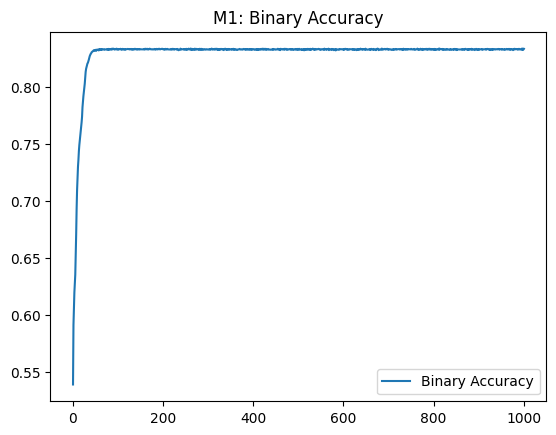

In [8]:
plot_history(history)

In [9]:
# Second model : does an extra unit reduction
def create_model_2(hidden_dense_1_size=256, plot_model=False, model_name='model2'):
    # Create the input units
    inputs = gen_unit_inputs(len(x_train))
    
    # Create the units on the inputs
    x = gen_units(inputs, size=2, activation='relu')
    
    # Unit reduction to size 3
    x = layers.concatenate(reduce_units(x, size=3, activation='relu'))
    
    # Hidden dense layer
    x = layers.Dense(hidden_dense_1_size, activation='relu', name='hidden_dense_1')(x)
    
    # Output layer
    outputs = layers.Dense(S, activation='sigmoid', name='output')(x)
    
    # Create the model
    model = keras.Model(inputs=inputs,
                        outputs=outputs)
    
    # Plot the model if specified
    if plot_model:
        keras.utils.plot_model(
            model,
            show_shapes=True,
            show_layer_names=True,
            show_layer_activations=True,
            to_file=f'{model_name}.png',
        )
    
    # Return the model
    return model

In [93]:
## Take results with a pinch of salt, can be very variable
## Train gets more gradual the lower the size
## Ran on 512 epochs
## Sizes with error: 16 (0.6984), 32 (0.8699), 64 (0.8585), 128 (0.8697), 256 (0.8330), 512 (0.80), 1024 (0.8673)
model2 = create_model_2(hidden_dense_1_size=32, plot_model=True)

OPTIMIZER = 'adam'
LOSS = 'binary_crossentropy'
METRICS = ['binary_accuracy']

EPOCHS = 500
BATCH_SIZE = 512 
## Doesn't change convergence much deteriorates after 512. 
## Curve gets a lot more angled with higher batch size.
## Makes sense as then epoch size needs to increase for
## to reach convergence
## Huge impact on speed.

model2.compile(
    optimizer=OPTIMIZER,
    loss=LOSS,
    metrics=METRICS,
)

history = model2.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
)

Epoch 1/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - binary_accuracy: 0.5057 - loss: 0.6961
Epoch 2/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.5430 - loss: 0.6634
Epoch 3/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.5832 - loss: 0.6334
Epoch 4/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.6080 - loss: 0.6185
Epoch 5/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.6238 - loss: 0.6065
Epoch 6/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.6392 - loss: 0.5937
Epoch 7/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.6545 - loss: 0.5788
Epoch 8/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.6670 - loss: 0.5660
Epoch 9/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.6743 - loss: 0.5566
Epoch 10/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.6836 - loss: 0.5469
Epoch 11/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - bin

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7504 - loss: 0.4232
Epoch 65/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7515 - loss: 0.4224
Epoch 66/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7518 - loss: 0.4213
Epoch 67/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7504 - loss: 0.4220
Epoch 68/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7511 - loss: 0.4213
Epoch 69/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7528 - loss: 0.4202
Epoch 70/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7511 - loss: 0.4212
Epoch 71/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7515 - loss: 0.4202
Epoch 72/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7529 - loss: 0.4192
Epoch 73/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7526 - loss: 0.4190
Epoch 74/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7687 - loss: 0.4010
Epoch 128/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7692 - loss: 0.4008
Epoch 129/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7683 - loss: 0.4006
Epoch 130/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7692 - loss: 0.4014
Epoch 131/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7680 - loss: 0.4003
Epoch 132/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7692 - loss: 0.3995
Epoch 133/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7695 - loss: 0.4003
Epoch 134/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7689 - loss: 0.4000
Epoch 135/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7684 - loss: 0.4004
Epoch 136/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7690 - loss: 0.3996
Epoch 137/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7896 - loss: 0.3763
Epoch 191/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7903 - loss: 0.3751
Epoch 192/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7895 - loss: 0.3757
Epoch 193/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7904 - loss: 0.3752
Epoch 194/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7903 - loss: 0.3748
Epoch 195/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7923 - loss: 0.3730
Epoch 196/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7900 - loss: 0.3742
Epoch 197/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7908 - loss: 0.3729
Epoch 198/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7913 - loss: 0.3732
Epoch 199/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7907 - loss: 0.3730
Epoch 200/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7965 - loss: 0.3566
Epoch 254/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7988 - loss: 0.3545
Epoch 255/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7956 - loss: 0.3566
Epoch 256/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7964 - loss: 0.3556
Epoch 257/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7976 - loss: 0.3550
Epoch 258/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7971 - loss: 0.3544
Epoch 259/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7991 - loss: 0.3533
Epoch 260/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7969 - loss: 0.3538
Epoch 261/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7975 - loss: 0.3550
Epoch 262/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7963 - loss: 0.3544
Epoch 263/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7994 - loss: 0.3477
Epoch 317/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7990 - loss: 0.3465
Epoch 318/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7990 - loss: 0.3473
Epoch 319/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7989 - loss: 0.3471
Epoch 320/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7979 - loss: 0.3477
Epoch 321/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7971 - loss: 0.3487
Epoch 322/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8002 - loss: 0.3467
Epoch 323/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7985 - loss: 0.3470
Epoch 324/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7991 - loss: 0.3462
Epoch 325/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7988 - loss: 0.3475
Epoch 326/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8010 - loss: 0.3432
Epoch 380/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8029 - loss: 0.3428
Epoch 381/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8025 - loss: 0.3428
Epoch 382/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8020 - loss: 0.3429
Epoch 383/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8013 - loss: 0.3432
Epoch 384/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8013 - loss: 0.3435
Epoch 385/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8021 - loss: 0.3434
Epoch 386/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8031 - loss: 0.3423
Epoch 387/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8034 - loss: 0.3421
Epoch 388/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8018 - loss: 0.3433
Epoch 389/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8060 - loss: 0.3396
Epoch 443/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8059 - loss: 0.3394
Epoch 444/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8059 - loss: 0.3394
Epoch 445/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8051 - loss: 0.3398
Epoch 446/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8048 - loss: 0.3396
Epoch 447/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8068 - loss: 0.3388
Epoch 448/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8067 - loss: 0.3401
Epoch 449/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8052 - loss: 0.3399
Epoch 450/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8056 - loss: 0.3390
Epoch 451/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8061 - loss: 0.3390
Epoch 452/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

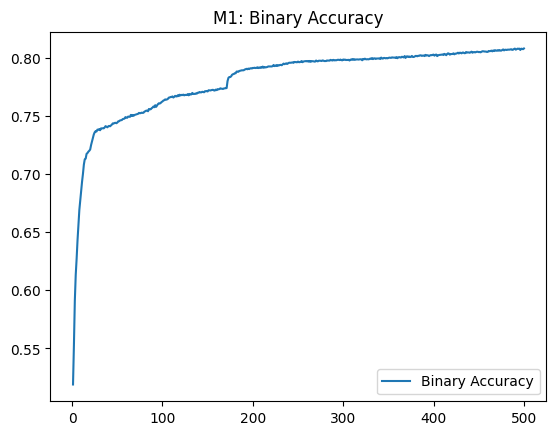

In [94]:
plot_history(history)

In [12]:
# Add more dense layers after the unit reduction
# Add an extra unit reduction to go from last layer of size 3
# to last layer of size 2
# Mess with different sizes of the dense layers after unit reduction
# Vary batch sizes